In [0]:
# Deep Neural Network

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import savetxt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

np.random.seed(1)

In [0]:
op_cases = 4
train_df = pd.read_csv("TrainData4.csv")
data_t = train_df.to_numpy()
x_train = data_t[:,1:29].T
y_train = data_t[:,29:33].T


test_df = pd.read_csv("TestData4.csv")
data_te = test_df.to_numpy()
x_test = data_te[:,1:29].T
y_test = data_te[:,29:33].T


In [8]:
print(x_train[0:8,0:2])

[[3.91920610e-02 2.02142949e-02]
 [1.71997159e-02 9.52831274e-03]
 [7.91911238e-05 6.84110490e-05]
 [2.20236400e-05 2.05897296e-05]
 [3.78447367e-01 4.25707494e-01]
 [5.36013269e-01 3.55327232e-01]
 [7.45205037e-01 8.31541503e-01]
 [1.53397031e-05 2.79077767e-05]]


In [0]:
def initialize_parameters_deep(layer_dims):    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))        

        assert(parameters['W' + str(l)].shape) == (layer_dims[l],layer_dims[l-1])
        assert(parameters['b' + str(l)].shape) == (layer_dims[l],1)    
    return parameters   

In [0]:
# calculate Z for forward propogation
def linear_forward(A, W, b):    
    
    Z = np.dot(W,A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    # storing parameters and A in cache
    cache = (A, W, b)
    
    return Z, cache

In [0]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)

    assert(A.shape==Z.shape)
    cache = Z
    return A, cache

def tanh(Z):
    A = ( np.exp(Z)-np.exp(-Z) )/( np.exp(Z)+np.exp(-Z))

    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

In [0]:
# forward propogation function
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = tanh(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [0]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 

    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],activation = "relu")
        caches.append(cache)

    AL,cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape== (op_cases,X.shape[1]))

    return AL, caches

In [0]:
def compute_cost(AL,Y):
    m = Y.shape[1]

    cost = -1/m * np.sum( Y*np.log(AL + 1e-20) + (1-Y)*np.log(1-AL + 1e-20))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [0]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ,A_prev.T)
    db = 1/m * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [0]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s =  1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert(dZ.shape == Z.shape)
    return dZ

def tanh_backward(dA,cache):
    Z = cache
    t = ( np.exp(Z)-np.exp(-Z) )/( np.exp(Z)+np.exp(-Z))
    dtanh = 1 - np.power(t,2)
    dZ = dA * dtanh

    assert(dZ.shape==Z.shape)
    return dZ

In [0]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    # linear cache  -> A_prev, W, b
    # activation cache -> Z
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [0]:
def L_model_backward(AL,Y,caches):
    #caches have [A W b Z] 
    grads={}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # find value of dAL, for initialising back prop. 
    dAL = - (np.divide(Y,AL) - np.divide(1-Y,1-AL))
    current_cache = caches[L-1]
    # caches is L-1 elemented list, ie. cache(1), cache(2) ......cache(L-1)
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = linear_activation_backward(dAL,current_cache,activation="sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,activation="relu")
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)] = db_temp

    return grads

In [0]:
# gradient descent
def update_parameters(parameters, grads, learning_rate):
   
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

In [0]:
def L_layer_model(X,Y,layer_dims,learning_rate = .0075,num_iterations=3000, print_cost = False, change_lr=False):
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layer_dims)

    for i in range(0,num_iterations):
        if( i==int(num_iterations*.7) and change_lr==True ):
            learning_rate = learning_rate*.7
            print("lr update")
        AL,caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)

        grads=L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)

        if(print_cost and i%500 ==0):
            print("cost after %i iterations = %f" %(i,cost))
        costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
# using last layer as sigmoid layer
def predict(X,Y,parameters):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    AL,caches = L_model_forward(X,parameters)
    predictions = np.zeros(Y.shape)
    for j in range(Y.shape[1]):
        max=0;
        for i in range(Y.shape[0]):
            if(AL[i,j]>=max):
                i_max = i 
                max = AL[i,j]
        predictions[i_max,j] = 1
    
    # finding accuracy
    I = np.identity(Y.shape[0], dtype = 'float')
    acc = (float( np.sum(np.dot(Y,predictions.T)*I) + np.sum(np.dot(1-Y,1-predictions.T)*I) )) / float(Y.size) * 100
    return predictions,acc

In [0]:
layers_dims = [28,13,7,4]

cost after 0 iterations = 2.772589
cost after 500 iterations = 2.317309
cost after 1000 iterations = 2.259092
cost after 1500 iterations = 2.249960
cost after 2000 iterations = 2.248385
cost after 2500 iterations = 2.248102
cost after 3000 iterations = 2.248050
cost after 3500 iterations = 2.248040
cost after 4000 iterations = 2.248039
cost after 4500 iterations = 2.248038
cost after 5000 iterations = 2.248038
cost after 5500 iterations = 2.248038
cost after 6000 iterations = 2.248038
cost after 6500 iterations = 2.248038
cost after 7000 iterations = 2.248038
cost after 7500 iterations = 2.248038
cost after 8000 iterations = 2.248038
cost after 8500 iterations = 2.248038
cost after 9000 iterations = 2.248038
cost after 9500 iterations = 2.248038
cost after 10000 iterations = 2.248038
cost after 10500 iterations = 2.248038
cost after 11000 iterations = 2.248038
cost after 11500 iterations = 2.248038
cost after 12000 iterations = 2.248038
cost after 12500 iterations = 2.248038
cost after

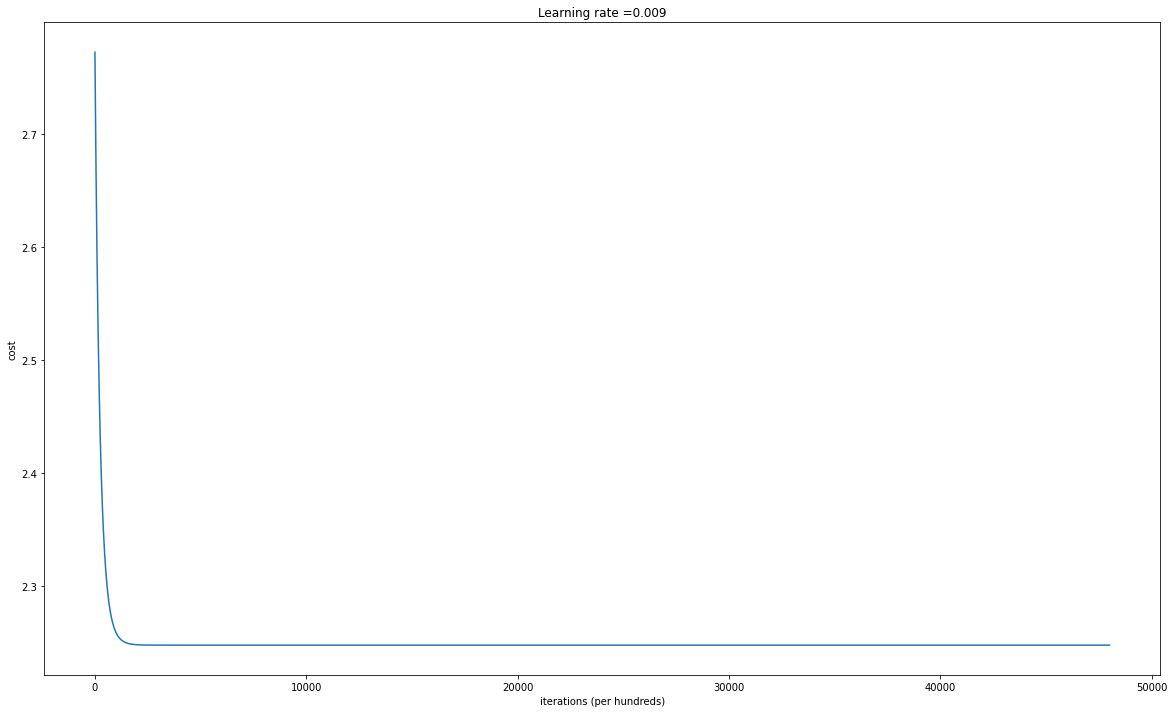

In [48]:
parameters = L_layer_model(x_train, y_train, layers_dims, learning_rate=.009 ,num_iterations = 48000, print_cost = True)

In [0]:
predictions_train,acc = predict(x_train, y_train, parameters)
predictions_test,acc_test = predict(x_test, y_test, parameters)


In [50]:
# with relu as activation function
print(acc,acc_test)

63.125 60.0


In [0]:
#choosing only mfcc1 and 2 and don't use tempo
x_train1 = x_train[1:10,:]
x_test1 = x_test[1:10,:]


cost after 0 iterations = 2.772649
cost after 500 iterations = 2.285034
cost after 1000 iterations = 2.251440
cost after 1500 iterations = 2.248369
cost after 2000 iterations = 2.248055
cost after 2500 iterations = 2.248015
cost after 3000 iterations = 2.247999
cost after 3500 iterations = 2.247981
cost after 4000 iterations = 2.247956
cost after 4500 iterations = 2.247920
cost after 5000 iterations = 2.247868
cost after 5500 iterations = 2.247794
cost after 6000 iterations = 2.247687
cost after 6500 iterations = 2.247533
cost after 7000 iterations = 2.247313
cost after 7500 iterations = 2.246995
cost after 8000 iterations = 2.246540
cost after 8500 iterations = 2.245887
cost after 9000 iterations = 2.244951
cost after 9500 iterations = 2.243613
cost after 10000 iterations = 2.241708
cost after 10500 iterations = 2.239006
cost after 11000 iterations = 2.235197
cost after 11500 iterations = 2.229877
cost after 12000 iterations = 2.222586
cost after 12500 iterations = 2.212754
cost after

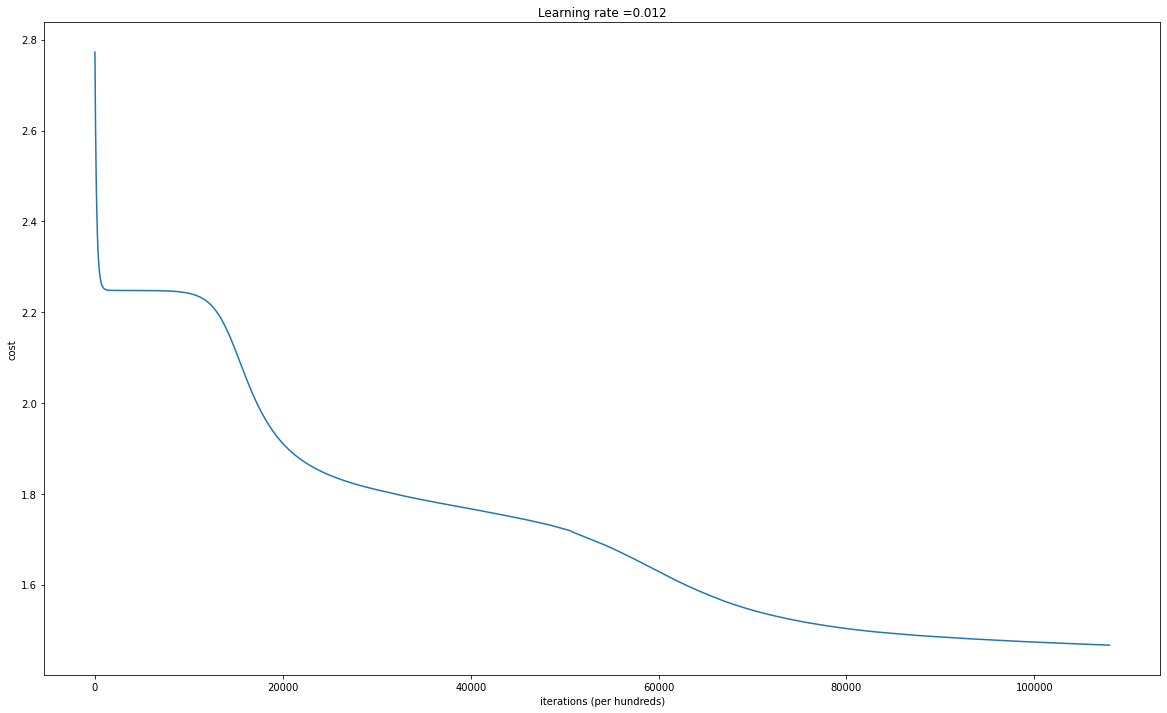

In [25]:
# layer
layers_dims = [9,6,4]
parameters = L_layer_model(x_train1, y_train, layers_dims, learning_rate=.012 ,num_iterations = 108000, print_cost = True)


In [26]:
predictions_train,acc = predict(x_train1, y_train, parameters)
predictions_test,acc_test = predict(x_test1, y_test, parameters)
print(acc,acc_test)

81.5625 75.0


In [0]:
#including mmfc 4,5,6,7,8
x_train2 = x_train[0:19,:]
x_test2 = x_test[0:19,:]


cost after 0 iterations = 2.772578
cost after 500 iterations = 2.341304
cost after 1000 iterations = 2.267180
cost after 1500 iterations = 2.252260
cost after 2000 iterations = 2.249001
cost after 2500 iterations = 2.248262
cost after 3000 iterations = 2.248091
cost after 3500 iterations = 2.248051
cost after 4000 iterations = 2.248041
cost after 4500 iterations = 2.248039
cost after 5000 iterations = 2.248038
cost after 5500 iterations = 2.248038
cost after 6000 iterations = 2.248038
cost after 6500 iterations = 2.248038
cost after 7000 iterations = 2.248038
cost after 7500 iterations = 2.248038
cost after 8000 iterations = 2.248038
cost after 8500 iterations = 2.248038
cost after 9000 iterations = 2.248038
cost after 9500 iterations = 2.248038
cost after 10000 iterations = 2.248038
cost after 10500 iterations = 2.248038
cost after 11000 iterations = 2.248038
cost after 11500 iterations = 2.248038
cost after 12000 iterations = 2.248038
cost after 12500 iterations = 2.248038
cost after

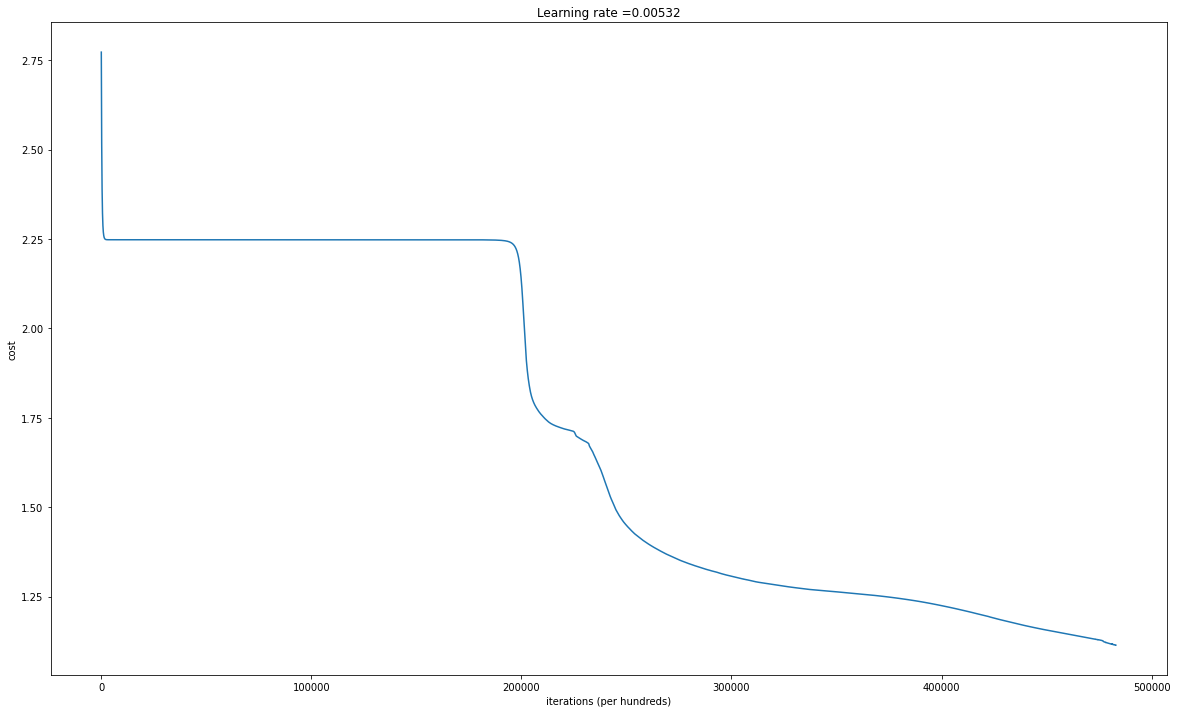

In [45]:
layers_dims = [19,13,9,4]
parameters = L_layer_model(x_train2, y_train, layers_dims, learning_rate=.0076 ,num_iterations = 483000, print_cost = True, change_lr=True)

In [46]:
predictions_train,acc = predict(x_train2, y_train, parameters)
predictions_test,acc_test = predict(x_test2, y_test, parameters)
print(acc,acc_test)

85.0 82.5
